# Naive transdimensional sampling

This notebook implements a naive transdimensional sampler that is based on a sequence of fixed-dimensional Metropolis-Hastings samplers. The goal is to estimate the coefficients of a polynomial of unknown degree.

## 0. Import some Python packages

We begin by importing some Python packages for random numbers and for plotting. 

In [1]:
# Some Python packages.

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set some parameters to make plots nicer.

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})

## 1. Artificial data

We will solve a synthetic inverse problem where we try to find the coefficients of a polynomial. For this, we compute artificial data using a polynomial of some degree $N_m-1$, where $N_m$ is the dimension of the model space. 

In a first step, we define (also for later convenience) a forward model function. In the second step, this is used to actually compute some artificial data that are polluted by normally distributed random errors.

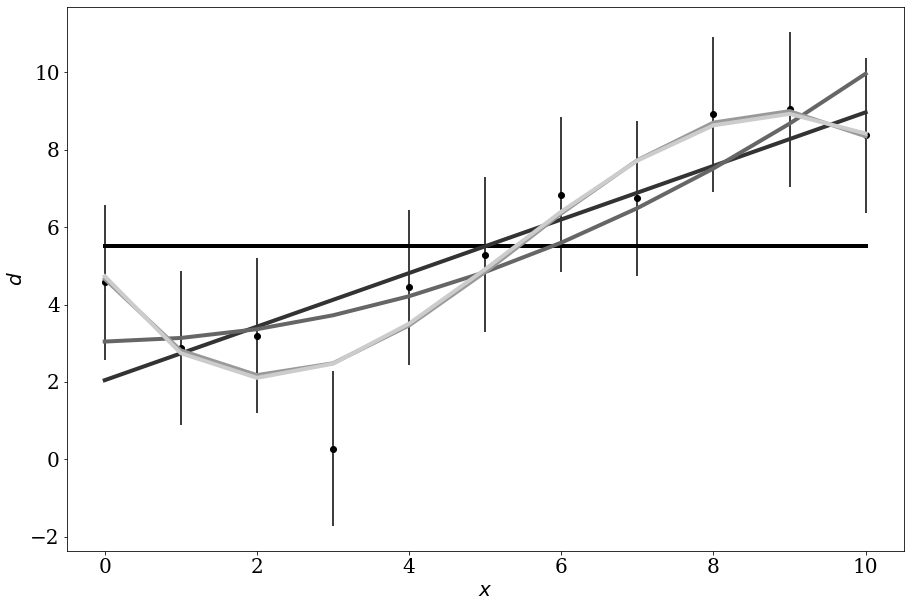

In [13]:
# Forward problem function. -------------------------------------------------

def forward(m, x, Nm):
    """
    Definition of the forward problem, which is a polynomial of degree Nm-1.

       y= m[0] + m[1]*x + m[2]*x**2.0 + ... + m[Nm-1]*x**(Nm-1) .

    :param m: Coefficients of the polynomial. Numpy array of dimension Nm.
    :param x: Scalar argument of the polynomial.
    :param Nm: Model space dimension.
    :return: Value of the polynomial at x.
    """

    d = 0.0

    for k in range(Nm):
        d+=m[k]*(x**(k))

    return d


# Input parameters for computation of artificial data. ----------------------

# Measurement locations.
x = np.arange(0.0,11.0,1.0)

# Model parameters and model space dimension.
m = np.array([1.0,1.0])
Nm = len(m)

# Standard deviation of the Gaussian errors.
sigma = 2.0

# Fixed random seed to make examples reproducible.
np.random.seed(3)

# Compute artificial data. --------------------------------------------------
d = forward(m, x, Nm) + sigma*np.random.randn(len(x))

# Plot data. ----------------------------------------------------------------

# Plot with errorbars.
plt.subplots(figsize=(15, 10))
plt.plot(x, d, 'ko')
plt.errorbar(x, d, yerr=sigma, xerr=0.0, ecolor='k', ls='none')

# Superimpose regression polynomials up to some degree.
for n in range(5):
    z = np.polyfit(x, d, n)
    p = np.poly1d(z)
    d_fit = p(x)
    plt.plot(x, d_fit,'k',color=[n/5,n/5,n/5],linewidth=4)

plt.xlabel('$x$')
plt.ylabel('$d$')
plt.savefig('transdim_data.pdf')
plt.show()

## 2. Fixed-dimensional Metropolis-Hastings sampling

The naive transdimensional sampler is based on fixed-dimensional sampling. This is done most conveniently (though probably not most efficiently) using global Metropolis-Hastings sampling with the fixed-dimensional prior as proposal distribution.

In our toy problem, the priors for all model parameters, regardless of dimension, are uniform. The fixed-dimensional likelihood function is Gaussian.

The output of the fixed-dimensional Metropolis-Hastings sampler is a collection of samples and the evidence (approximated by the samples). Some care must be taken here with the size of the problem because all samples are kept in memory!

In [ ]:
# Fixed-dimensional Metropolis-Hastings sampler. ----------------------------

def mh(x, d, sigma, Nm, Nsamples):
    """
    Run the Metropolis-Hastings algorithm to sample the fixed-dimensional posterior.

    All priors on the model parameters are uniform.

    :param x: Measurement locations. Needed to evaluate the forward problem.
    :param d: Data.
    :param sigma: Standard deviation of the data errors.
    :param Nm: Model space dimension.
    :param Nsamples: Total number of samples in the Metropolis-Hastings sampling.
    :return: samples, evidence. Vector containing the samples, plus the evidence.
    """

    #- Initialisation. ------------------------------------------------------

    # Allowable range of the model parameters around 0.
    m_range = 5.0

    # Allocate empty vectors to collect samples.
    samples = np.zeros((Nm, Nsamples))

    # Compute initial misfit.
    m_current = 2.0*m_range*(np.random.rand(Nm)-0.5)
    d_current = forward(m_current, x, Nm)
    x_current = np.sum(((d - d_current)**2.0)/(2.0*sigma**2.0))

    # Assign first sample and start accumulating the evidence.
    samples[:, 0] = m_current
    evidence = np.exp(-x_current)

    # Sampling. -------------------------------------------------------------

    for k in range(1,Nsamples):

        # Test sample and misfit.
        m_test = 2.0 * m_range * (np.random.rand(Nm) - 0.5)
        d_test = forward(m_test, x, Nm)
        x_test = np.sum(((d - d_test) ** 2.0) / (2.0 * sigma ** 2.0))

        # Accumulate evidence.
        evidence += np.exp(-x_test)

        # Metropolis rule (in logarithmic form, to avoid exponential overflow).
        p = np.minimum(0.0, -x_test+x_current)
        if p >= np.log(np.random.rand(1)):
            m_current = m_test
            x_current = x_test

        samples[:, k] = m_current

    return samples, evidence

## 3. Run the fixed-dimensional sampler

We now actually run the fixed-dimensional sampler for all model space dimensions that we consider. Along the way, we compute the fixed-dimensional evidence, $\rho(\mathbf{d}|N_m)$. To obtain a reasonable posterior, around 100'000 should be used.

In [ ]:
# Input parameters. ---------------------------------------------------------

# Estimated standard deviation of the data errors.
sigma=2.0

# Maximum allowable dimension of the model space.
Nm_max=4

# Total number of samples in each fixed-dimensional sampler.
Nsamples=100000

# Run fixed dimensional sampler. --------------------------------------------

# Initialise lists for the samples and for the evidence.
s=[]
e=[]

# Individual, fixed-dimensional Metropolis-Hastings runs.
for Nm in range(1, Nm_max+1):
    samples, evidence = mh(x, d, sigma, Nm, Nsamples)
    s.append(samples)
    e.append(evidence)

## 4. Fixed-dimensional marginals

Using the fixed-dimensional samples, we may plot fixed-dimensional posterior marginals.

In [ ]:
# Plot some fixed-dimensional marginals. ------------------------------------

# Fixed model space dimension to plot.
dimension=2
# Model parameter index to plot. (Between 0 and dimension-1.)
parameter=1

plt.hist(s[dimension-1][parameter,:], bins=15, color='k')
plt.xlabel('m'+str(dimension+1))
plt.ylabel('posterior marginal')
plt.show()

## 5. Posterior distribution of model space dimension

Using Bayes' theorem for model space dimension, $\rho(N_m | \mathbf{d}) = \rho(\mathbf{d}|N_m) / \rho(\mathbf{d})$, we can compute the posterior for model space dimension, $\rho(N_m | \mathbf{d})$. (Here we already assumed that the prior on model space dimension, $\rho(N_m)$, is uniform.) For this, we first compute the total evidence $\rho(\mathbf{d})$ from the normalisation condition, $\rho(\mathbf{d}) = \sum_{N_m} \rho(\mathbf{d}|N_m)$. Finally, we simply divide the conditional evidence $\rho(\mathbf{d}|N_m)$ by the total evidence $\rho(\mathbf{d})$.

In [ ]:
# Total (unnormalised) evidence.
e_total = sum(e)
e = e/e_total

# Plot marginal for dimension.
x = np.arange(1, Nm_max+1)
plt.bar(x, e, align='center', color='k')
plt.yscale('log', nonposy='clip')
plt.xlabel('dimension')
plt.ylabel('posterior')
plt.show()